<h1>Analysis 3 - Time series analysis</h1>

This is based on Shaohua Liu workbook Analysis 2 (20/5/2021)

<h2>Section 1 - Preprocessing</h2>

In [1]:
import pandas as pd
import numpy as np
from glob import glob
import requests
import json
import seaborn as sns
import re
from datetime import datetime
from datetime import date


In [2]:
def parse_CL(site):
    df = pd.concat([pd.read_csv(file) for file in glob(f'Ceilometer/*{site}.csv')])

    # replace -999 to NaN
    df = df.replace(-999, np.nan)

    # parse date string
    df['# Time'] = pd.to_datetime(df['# Time'], format='%d/%m/%Y %H:%M:%S')
    
    # interpolate bl_height by time
    df['revised_bl_height'] = df.set_index('# Time')['bl_height'].interpolate(method='time').values

    # aggregate bl_height by hourly average
    df = df.groupby([
        df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['# Time'].dt.hour.rename('Hour')
    ])['revised_bl_height'].mean().reset_index(name='CL_BLH').set_index(['Date', 'Hour'])

    return df

In [3]:
def parse_CTM(site, time_offset=10):
    # Careful! The seperator is not ',' but ', ' (space)
    df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'CTM_ModelOutput/*{site}.csv')])

    # parse date string
    from datetime import timedelta
    df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

    df = df.groupby([
        df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['Time'].dt.hour.rename('Hour')
    ])['mixing_height'].mean().reset_index(name='CTM_BLH').set_index(['Date', 'Hour'])

    return df

In [9]:
'''
2. Import WRF data
'''

data_path = "D:\MSDS\DS Project\Data"

wrf_data_path = "\\WRF"

wrf_data_fn_merriwa = ['PBLH_series329_20210212', 'PBLH_series329_20210213',
                       'PBLH_series329_20210214','PBLH_series329_20210215',
                       'PBLH_series329_20210216','PBLH_series329_20210217',
                      'PBLH_series329_20210218']

#Use RE
wrf_data_fn_lidcombe = [re.sub('series329', 'series2141',data) for data in wrf_data_fn_merriwa]

wrf_full_file_path_merriwa = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_merriwa]
wrf_full_file_path_lidcombe = [data_path+wrf_data_path+'\\'+path+'.txt' for path in wrf_data_fn_lidcombe]

#Initialise a Dataframe with first table
wrf_df_merriwa = pd.read_csv(wrf_full_file_path_merriwa[0], header = None, delimiter = r'\s+')
wrf_df_lidcombe = pd.read_csv(wrf_full_file_path_lidcombe[0], header = None, delimiter = r'\s+')

#Loop through the rest of the data and append. Note both data is same length
for i in range(1,len(wrf_full_file_path_merriwa)):
    wrf_df_merriwa = wrf_df_merriwa.append(pd.read_csv(wrf_full_file_path_merriwa[i], header = None, delimiter = r'\s+') , ignore_index = True)
    wrf_df_lidcombe = wrf_df_lidcombe.append(pd.read_csv(wrf_full_file_path_lidcombe[i], header=None, delimiter = r'\s+'),  ignore_index = True)
    
wrf_df_merriwa = wrf_df_merriwa.rename(columns = {0:'datetime', 1:'WRF PBLH'})
wrf_df_lidcombe = wrf_df_lidcombe.rename(columns = {0:'datetime', 1:'WRF PBLH'})


wrf_df_merriwa['date'] = wrf_df_merriwa.datetime.str[:10]
wrf_df_merriwa['time'] = wrf_df_merriwa.datetime.str[11:13].astype(int)

wrf_df_lidcombe['date'] = wrf_df_lidcombe.datetime.str[:10] 
wrf_df_lidcombe['time'] = wrf_df_lidcombe.datetime.str[11:13].astype(int)



In [27]:
def convert_df_to_datetime_wrf(df):
    df['time_AEST'] = (df['time'] + 10) % 24

    #Loop through and convert date to proper date
    length_data = len(df)

    #Defined new columns
    df['date_proper'] = 0
    df['datetime'] = ''

    #Sets the date based on change of time and creates a datetime stamp
    #Very clunky but it works
    for i in range(length_data):
        date_1 = str(df.loc[i,'date'])

        year_date_1 = date_1[:4]
        month_date_1 = date_1[5:7]
        day_date_1 = int(date_1[8::])

        if i > 1:
            #This means the day has changed
            if (df.loc[i,'time_AEST'] < df.loc[i-1,'time_AEST']):
                day_date_1 += 1

        df.loc[i, 'date_proper'] = date(int(year_date_1), int(month_date_1), day_date_1)

        #Days are monotonic
        if i > 1:
            if (df.loc[i,'date_proper'] < df.loc[i-1,'date_proper']):
                df.loc[i,'date_proper'] = df.loc[i-1,'date_proper']

        date_proper_1 = str(df.loc[i,'date_proper'])
        time_1 = str(df.loc[i, 'time_AEST'])

        datetime_str = date_proper_1 + " " + time_1
        df.loc[i, 'datetime'] = datetime.strptime(datetime_str, '%Y-%m-%d %H')

    df = df[~df.index.duplicated(keep = 'first')]
    
    df['datetime'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%d %H')
    #Set index to datetime
    df = df.groupby([
        df['datetime'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['datetime'].dt.hour.rename('Hour')
    ])['WRF PBLH'].mean().reset_index(name='WRF_BLH').set_index(['Date', 'Hour'])

    
    return df

In [28]:
wrf_df_merriwa = convert_df_to_datetime_wrf(wrf_df_merriwa)
wrf_df_lidcombe = convert_df_to_datetime_wrf(wrf_df_lidcombe)


In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

def join_CL_CTM_WRF(site, wrf_df):
    CLdf = parse_CL(site)
    CTMdf = parse_CTM(site)
    WRFdf = wrf_df.copy(deep = True)
    
    df_joined = CLdf.join(CTMdf, how='inner')
    
    df_joined = df_joined.join(WRFdf, how = 'inner')
    return df_joined

def bl_plot(site, wrf_df):
    join_df = join_CL_CTM_WRF(site, wrf_df).reset_index()
    join_df['Time'] = pd.to_datetime(join_df[['Date', 'Hour']].astype(str).apply('-'.join, 1), format='%Y-%m-%d-%H')
    join_df.plot(x='Time', y=['CL_BLH', 'CTM_BLH', 'WRF_BLH'], title=site)
    plt.show()

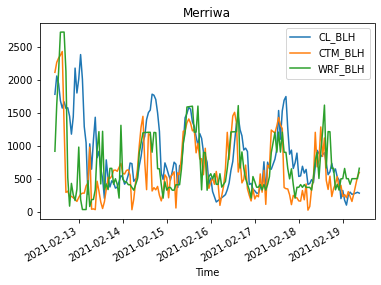

In [36]:
bl_plot('Merriwa', wrf_df_merriwa)


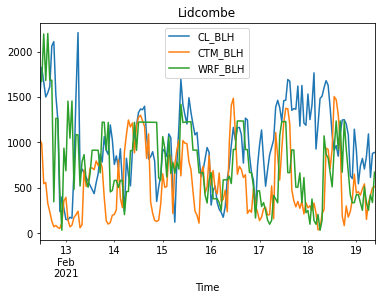

In [37]:
bl_plot('Lidcombe', wrf_df_lidcombe)


In [42]:
class AQMS_API:
    def __init__(self):
        self.url_prefix = 'https://data.airquality.nsw.gov.au/api/Data/'
        self.headers = {
            'content-type': 'application/json',
            'accept': 'application/json',
        }
        
        self.site_url = 'get_SiteDetails'
        self.parameter_url = 'get_ParameterDetails'
        self.observation_url = 'get_Observations'
        
    def get_data(self, url_suffix, http_method=requests.get, data=None):
        query = self.url_prefix + url_suffix
        response = http_method(url=query, headers=self.headers, json=data)
        return response.json()
    
    def get_sites(self):
        return self.get_data(self.site_url)
    
    def get_parameters(self):
        return self.get_data(self.parameter_url)
    
    def get_observations(self, data=None):
        return self.get_data(self.observation_url, requests.post, data)

# historical observation query builder
def obs_builder(parameter=None, sites=None, start=None, end=None, category=None, sub_category=None, freq=None):
    '''
    start & end : '%Y-%m-%d' format date string
    '''
    def list_parser(s):
        if s is None or isinstance(s, list):
            return s
        else:
            return [s]

    return {
        'Parameters': list_parser(parameter),
        'Sites': list_parser(sites),
        'StartDate': start,
        'EndDate': end,
        'Categories': list_parser(category),
        'SubCategories': list_parser(sub_category),
        'Frequency': list_parser(freq),
    }

In [43]:
api = AQMS_API()

# site id
sites = {
    'Merriwa': 329,
    'Lidcombe': 1141,
}

In [44]:
df = pd.DataFrame.from_records(api.get_parameters())
params = df.loc[
    (df['Category'] == 'Averages') & 
    (df['SubCategory'] == 'Hourly') & 
    (df['Frequency'] == 'Hourly average')
]
#params

In [45]:
#TK 28/7/2021: Added BL diff - can/should we use this as a feature..?
def bl_external(site, site_id):
    query = obs_builder(
        params['ParameterCode'].tolist(), 
        site_id, 
        '2021-02-12',
        '2021-02-19',
        'Averages', 
        'Hourly', 
        'Hourly average'
    )
    obs = pd.DataFrame.from_records(api.get_observations(query))
    obs['Hour'] = obs['Hour'] - 1
    obs['Parameter'] = pd.json_normalize(obs['Parameter'])['ParameterDescription']
    obs = pd.pivot(obs, index=['Date', 'Hour'], columns='Parameter', values='Value').reset_index()
    
    if site == 'Merriwa':
        wrf_df = wrf_df_merriwa
    else:
        wrf_df = wrf_df_lidcombe
    
    df = join_CL_CTM_WRF(site, wrf_df).join(obs.set_index(['Date', 'Hour']), how='inner').reset_index()
    df['BL_diff'] =df['CL_BLH'] - df['CTM_BLH'] 
    return df

In [9]:
#df = bl_external('Merriwa', 329)
#df

In [46]:
data = {site: bl_external(site, id) for site, id in sites.items()}

<h2>Section 2 - Correlation analysis</h2>

In [47]:
def get_df(site):
    if site == 'all':
        df = pd.concat(data.values()).drop(columns='Solar radiation')
    else:
        df = data[site]
    return df.dropna().set_index(['Date', 'Hour'])

def corr(site, method='pearson'):
    return get_df(site).corr(method=method)

from scipy.stats import pearsonr

def p_value(site):
    df = get_df(site)._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues

In [49]:
corr('all', 'pearson').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,1.000000,0.287952,0.421003
CTM_BLH,0.287952,1.000000,0.533182
WRF_BLH,0.421003,0.533182,1.000000
Carbon monoxide,0.092702,-0.184646,0.071361
Humidity,-0.667230,-0.518442,-0.615021
Nephelometer,0.006918,-0.173402,-0.085122
Nitric Oxide,0.144480,-0.125607,-0.188269
Nitrogen Dioxide,0.011283,-0.424918,-0.286374
Ozone,0.468203,0.455442,0.619387
PM10,0.352813,-0.023971,0.139337


In [50]:
p_value('all').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,0.0,0.000001,0.0
CTM_BLH,0.000001,0.0,0.0
WRF_BLH,0.0,0.0,0.0
Carbon monoxide,0.125132,0.002108,0.238198
Humidity,0.0,0.0,0.0
Nephelometer,0.909081,0.003923,0.159214
Nitric Oxide,0.016502,0.037367,0.001713
Nitrogen Dioxide,0.852237,0.0,0.000001
Ozone,0.0,0.0,0.0
PM10,0.0,0.692281,0.02081


In [51]:
# available method [‘pearson’, ‘kendall’, ‘spearman’]
corr('Lidcombe', 'pearson').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,1.000000,0.136481,0.280939
CTM_BLH,0.136481,1.000000,0.240733
WRF_BLH,0.280939,0.240733,1.000000
Carbon monoxide,-0.284860,-0.460941,-0.024760
Humidity,-0.576953,-0.437755,-0.520178
Nephelometer,-0.313251,-0.311381,-0.368367
Nitric Oxide,0.152507,-0.249707,-0.405554
Nitrogen Dioxide,-0.013995,-0.600630,-0.427132
Ozone,0.328640,0.399086,0.712369
PM10,0.138696,-0.119004,0.038611


In [52]:
p_value('Lidcombe').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,0.0,0.140567,0.002059
CTM_BLH,0.140567,0.0,0.008641
WRF_BLH,0.002059,0.008641,0.0
Carbon monoxide,0.001769,0.0,0.790133
Humidity,0.0,0.000001,0.0
Nephelometer,0.000553,0.000599,0.000041
Nitric Oxide,0.099213,0.006392,0.000005
Nitrogen Dioxide,0.880438,0.0,0.000001
Ozone,0.00028,0.000008,0.0
PM10,0.134177,0.19931,0.678058


In [53]:
corr('Merriwa', 'pearson').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,1.000000,0.395865,0.496932
CTM_BLH,0.395865,1.000000,0.701255
WRF_BLH,0.496932,0.701255,1.000000
Carbon monoxide,0.522859,0.200391,0.354947
Humidity,-0.755757,-0.597379,-0.697415
Nephelometer,-0.128754,-0.089435,-0.041753
Nitric Oxide,0.052930,0.150851,0.130233
Nitrogen Dioxide,-0.104132,-0.312676,-0.256490
Ozone,0.695825,0.497777,0.627332
PM10,0.475645,0.091247,0.202267


In [54]:
p_value('Merriwa').iloc[:, :3]

,CL_BLH,CTM_BLH,WRF_BLH
CL_BLH,0.0,0.0,0.0
CTM_BLH,0.0,0.0,0.0
WRF_BLH,0.0,0.0,0.0
Carbon monoxide,0.0,0.011856,0.000005
Humidity,0.0,0.0,0.0
Nephelometer,0.108036,0.265323,0.603615
Nitric Oxide,0.510299,0.059313,0.104013
Nitrogen Dioxide,0.194331,0.000067,0.001185
Ozone,0.0,0.0,0.0
PM10,0.0,0.255725,0.011071


<h2>Section 3 - Ensemble modelling</h3>

<h4>Data config</h4>

In [55]:
#Get data from dict
df_merriwa = data['Merriwa']
df_lidcombe = data['Lidcombe']

#sanity check
#df_merriwa

In [56]:
df_merriwa.head()

,Date,Hour,CL_BLH,CTM_BLH,WRF_BLH,Carbon monoxide,Humidity,Nephelometer,Nitric Oxide,Nitrogen Dioxide,Ozone,PM10,PM2.5,Rainfall,Sulphur Dioxide,Temperature,Wind Direction (10m),Wind Direction Sigma Theta,Wind Speed (10m),BL_diff
0,2021-02-12,11,1782.971698,2116.5154,918.04,-0.013024,47.927,0.042,-0.023461,0.069158,2.54408,23.290,1.629,0.0,0.012478,26.696,331.472,14.912,7.140,-333.543702
1,2021-02-12,12,2060.904255,2268.4509,1629.29,-0.003834,46.820,0.051,-0.015987,0.076345,2.84378,18.506,7.472,0.0,0.009091,27.329,341.235,15.817,5.896,-207.546645
2,2021-02-12,13,1942.894737,2332.6211,2124.96,-0.004704,45.996,0.058,-0.011745,0.066663,3.05318,22.723,6.195,0.0,0.016463,28.087,345.758,13.917,6.096,-389.726363
3,2021-02-12,14,1684.731183,2376.4629,2726.00,-0.003592,44.181,0.060,-0.026188,0.057879,3.26518,19.386,2.025,0.0,0.031706,28.844,333.913,13.932,6.070,-691.731717
4,2021-02-12,15,1573.967391,2432.8503,2727.78,-0.002880,43.716,0.065,-0.021037,0.052190,3.34748,19.332,-4.037,0.0,0.039776,29.141,339.577,17.870,5.807,-858.882909


In [57]:
'''
There are NaNs in external factors. Just fill them in. This as opposed to dropping data with missing values
'''
def interpolate_external_factors(df):

    df['datetime'] = pd.to_datetime(df['Date'] +' '+ df['Hour'].astype(str)+':00', format = '%Y-%m-%d %H:%M')

    feature_list_all = [feature for feature in df.columns][4:len(df.columns)-2]

    for feature in feature_list_all:
        df[feature] = df.set_index('datetime')[feature].interpolate(method='time').values
        
    return df

In [58]:
df_merriwa_filled = interpolate_external_factors(df_merriwa)
df_lidcombe_filled = interpolate_external_factors(df_lidcombe)

In [11]:
'''
Not really used - just for curiosity
'''
#Split data
#df_merriwa_cl = df_merriwa.drop(columns = ['CTM_BLH','BL_diff'])
#df_lidcombe_cl = df_lidcombe.drop(columns = ['CTM_BLH','BL_diff'])

#sanity check
#df_merriwa_cl

In [59]:
#Creates functions with lags and differences up to d
def create_data_lags(df, d):

    df_func = df.copy(deep = True)

    for i in range(d):
        col_name = 'CL_BLH_lag'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].shift(i+1)

    #Double for loop not the best - but want to keep factors at different locations to each other to easier view
    for i in range(d):
        col_name = 'CL_BLH_diff'+str(i+1)
        df_func[col_name] = df_func['CL_BLH'].diff(periods = i+1)
    
    return df_func

In [60]:
df_merriwa_wlags = create_data_lags(df_merriwa_filled, 5)
df_lidcombe_wlags = create_data_lags(df_lidcombe_filled, 5)

In [61]:
df_lidcombe_wlags.columns

Index(['Date', 'Hour', 'CL_BLH', 'CTM_BLH', 'WRF_BLH', 'Carbon monoxide',
       'Humidity', 'Nephelometer ', 'Nitric Oxide', 'Nitrogen Dioxide',
       'Ozone', 'PM10', 'PM2.5', 'Rainfall', 'Solar radiation',
       'Sulphur Dioxide', 'Temperature', 'Wind Direction (10m) ',
       'Wind Direction Sigma Theta', 'Wind Speed (10m)  ', 'BL_diff',
       'datetime', 'CL_BLH_lag1', 'CL_BLH_lag2', 'CL_BLH_lag3', 'CL_BLH_lag4',
       'CL_BLH_lag5', 'CL_BLH_diff1', 'CL_BLH_diff2', 'CL_BLH_diff3',
       'CL_BLH_diff4', 'CL_BLH_diff5'],
      dtype='object')

<h5>Defining the statistical comparison measures - as per analysis 1</h5>

In [62]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [63]:
'''
Stolen from: https://github.com/rkawsar/ambhas/blob/master/ambhas/errlib.py

This basically looks like a modified version of R2?
'''

def index_agreement(s, o):
    """
    index of agreement

    Willmott (1981, 1982) 
    input:
        s: simulated
        o: observed
    output:
        ia: index of agreement
    """
    ia = 1 -(np.sum((o-s)**2))/(np.sum((np.abs(s-np.mean(o))+np.abs(o-np.mean(o)))**2))
    return ia

In [64]:
'''
Calculate mean bias error
'''
def mean_bias_error(y_true, y_pred):
    return np.mean(y_pred - y_true)


In [65]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def DTW_dist(y_true, y_pred):
    distance, path = fastdtw(y_true, y_pred, dist=euclidean)
    
    return distance, path

In [66]:
'''
Function: Calculates and prints out the varoius metrics
'''

def satistical_comps_on_df(y_true, y_pred, location):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    
    print('At %s\nIndex of agreement:%.5f\nRoot mean squared error:%.5f\nMean absoluate error:%.5f\nMean bias error:%.5f\nDTW distance:%.2f' % (location, ioa, rmse, mae, mbe, dtw_dist))

In [67]:
#Write into DF
def satistical_comps_on_df_to_df(y_true, y_pred):    
    y_true = y_true.to_numpy()
    y_pred = y_pred.to_numpy()
    
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mbe = mean_bias_error(y_true, y_pred)
    ioa = index_agreement(y_pred, y_true)
    dtw_dist, path = DTW_dist(y_true, y_pred)
    
    df = pd.DataFrame([ioa, rmse, mae, mbe, dtw_dist])
    
    return df

<h5>Base comp stats - assuming gold standard is CT and WRF model</h5>

On CTM

In [68]:
satistical_comps_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['CTM_BLH'], 'Merriwa CTM model')

At Merriwa CTM model
Index of agreement:0.83320
Root mean squared error:212.95909
Mean absoluate error:171.77558
Mean bias error:-21.58962
DTW distance:3611.44


In [69]:
satistical_comps_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['CTM_BLH'], 'Lidcombe CTM model')

At Lidcombe CTM model
Index of agreement:0.39774
Root mean squared error:585.35820
Mean absoluate error:505.07921
Mean bias error:-375.16142
DTW distance:12043.29


On WRF

In [71]:
satistical_comps_on_df(df_merriwa_filled.tail(24)['CL_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'], 'Merriwa WRF model')

At Merriwa WRF model
Index of agreement:0.64988
Root mean squared error:333.80451
Mean absoluate error:274.93361
Mean bias error:180.78693
DTW distance:5860.68


In [72]:
satistical_comps_on_df(df_lidcombe_filled.tail(24)['CL_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'], 'Lidcombe WRF model')

At Lidcombe WRF model
Index of agreement:0.53857
Root mean squared error:458.91711
Mean absoluate error:384.71552
Mean bias error:-343.37658
DTW distance:9781.22


<h5>Feature list</h5>

In [73]:
feature_list = ['Carbon monoxide',
 'Humidity',
 'Nephelometer ',
 'Ozone',
 'Temperature',
 'Wind Direction Sigma Theta']

In [76]:
feature_list_all = [feature for feature in df_merriwa.columns][5:len(df_merriwa.columns)-2]

# feature_list_all

In [77]:
#Feature including BL diff as predictor.
feature_list_all_v2 = [feature for feature in df_merriwa.columns][5:len(df_merriwa.columns)-1]

In [79]:
#Feature list with lags
feature_list_all_wlags = feature_list_all.copy()

feature_list_all_wlags.extend(['CL_BLH_lag1', 'CL_BLH_lag2','CL_BLH_lag3','CL_BLH_lag4','CL_BLH_lag5'])

# feature_list_all_wlags

In [81]:
#extend feature list with lags to include diffs:
feature_list_all_v3 = feature_list_all_wlags.copy()

feature_list_all_v3.extend(['CL_BLH_diff1', 'CL_BLH_diff2','CL_BLH_diff3','CL_BLH_diff4','CL_BLH_diff5'])

# feature_list_all_v3

<h5>Generic modelling functions</h5>

In [83]:
'''
Define a generic modeller function

Inputs:
- df: dataframe object
- feature_list: list of features
- target: target variable
- modeller: base model to fit

Returns:
- df_result: dataframe of results

'''
def modeller(df, feature_list, target, modeller):
    '''
    Define train test split
    '''
    train = df.head(142).dropna()
    test = df.tail(24)
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    '''
    Train model
    '''
    modeller.fit(X_train, y_train)

    '''
    Predict
    '''
    modeller_predict = modeller.predict(X_test)
    
    '''
    Write to dataframe
    '''
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  modeller_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    return df_result


In [84]:
def pred_plots(df, title):
    resid_plot_title = 'Residual plots at '+ title
    pred_plot_title = 'Comparison of predicted BLH at ' + title
    
    sns.set_theme(style="whitegrid")

    # Make an example dataset with y ~ x
    x = df['CL_BLH']
    y = df['Predicted BLH']

    # Plot the residuals after fitting a linear model
    sns.residplot(x=x, y=y, lowess=True, color="g").set(title = resid_plot_title)
    df.plot(title = pred_plot_title)

In [85]:
def results_print(df, title):
    pred_plots(df, title)
    satistical_comps_on_df(df['CL_BLH'], df['Predicted BLH'], title)

<h3>GBM methods</h3>

The idea is to use boosting methods as applied to time series based on feature set to develop an ensemble model. Will use linear regressors

4/8/2021 - General thoughts
* BM seem to work OK
* There are many different algos though - each with its own fine tuning needs
* Explore more ensemble methods?
* GBM vs Ada?

<h4>XGBoost</h4>

General thoughts:
* Easy to train
* Does this overfit as number of trees increase? Need to think carefully
* Tuning hyper-params?
* Feature selection still an issue - H0 tests? ANOVA?

In [86]:
from xgboost import XGBRegressor

<h5>On all features</h5>

In [104]:
# n_estimators=500, learning_rate=0.01

xgbm_model = XGBRegressor()

df_merriwa_xgbm_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', xgbm_model)
df_lidcombe_xgbm_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', xgbm_model)

C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


At Merriwa XGBM all features
Index of agreement:0.73466
Root mean squared error:319.03948
Mean absoluate error:280.90060
Mean bias error:280.90060
DTW distance:6940.82


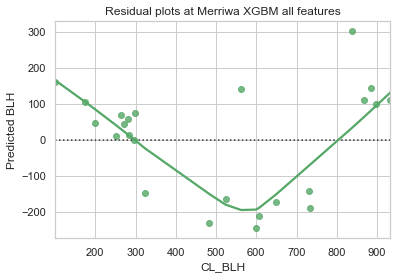

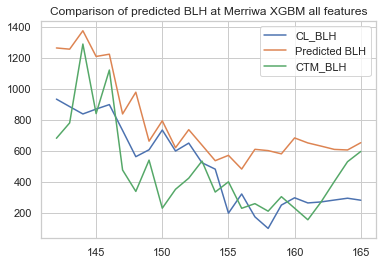

In [105]:
results_print(df_merriwa_xgbm_all, 'Merriwa XGBM all features')

At Lidcombe XGBM all features
Index of agreement:0.55294
Root mean squared error:358.77947
Mean absoluate error:277.25321
Mean bias error:51.77140
DTW distance:6171.76


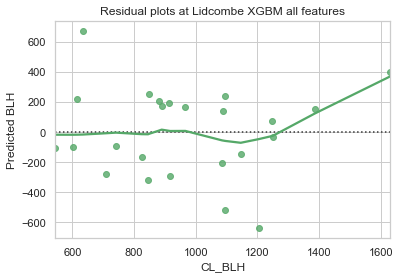

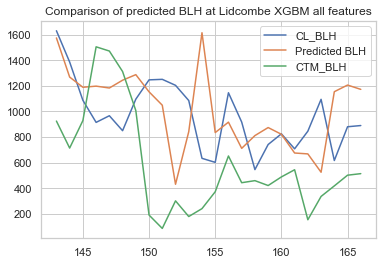

In [106]:
results_print(df_lidcombe_xgbm_all, 'Lidcombe XGBM all features')

<h5>With lags</h5>

In [107]:
df_merriwa_xgbm_wlags = modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH', xgbm_model)
df_lidcombe_xgbm_wlags = modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH', xgbm_model)

C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


At Merriwa XGBM with lags
Index of agreement:0.73656
Root mean squared error:271.41178
Mean absoluate error:222.58251
Mean bias error:215.87148
DTW distance:3730.32


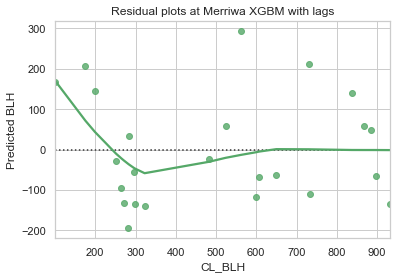

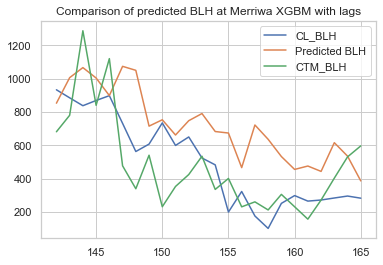

In [108]:
results_print(df_merriwa_xgbm_wlags, 'Merriwa XGBM with lags')

Clear improvement!!

At Lidcombe XGBM with lags
Index of agreement:0.75308
Root mean squared error:269.94877
Mean absoluate error:227.49795
Mean bias error:56.22532
DTW distance:3055.11


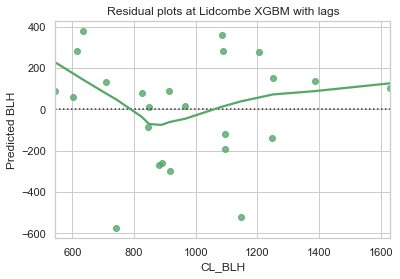

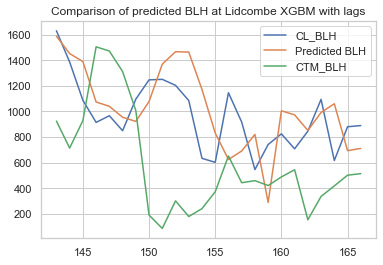

In [109]:
results_print(df_lidcombe_xgbm_wlags, 'Lidcombe XGBM with lags')

<h5>With diff and lags</h5>

In [110]:
df_merriwa_xgbm_wlags_v2 = modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH', xgbm_model)
df_lidcombe_xgbm_wlags_v2 = modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH', xgbm_model)

C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


At Merriwa XGBM with lags and diffs
Index of agreement:0.94313
Root mean squared error:107.15248
Mean absoluate error:75.79342
Mean bias error:30.89492
DTW distance:1787.35


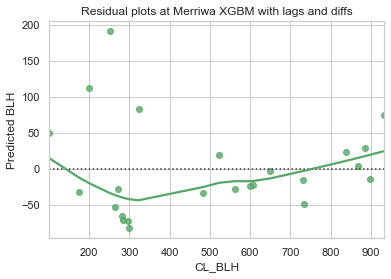

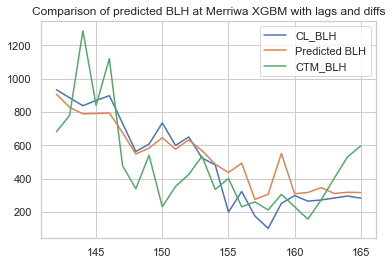

In [111]:
results_print(df_merriwa_xgbm_wlags_v2, 'Merriwa XGBM with lags and diffs')

At Merriwa XGBM with lags and diffs
Index of agreement:0.96467
Root mean squared error:94.97555
Mean absoluate error:71.32196
Mean bias error:-25.83419
DTW distance:1711.73


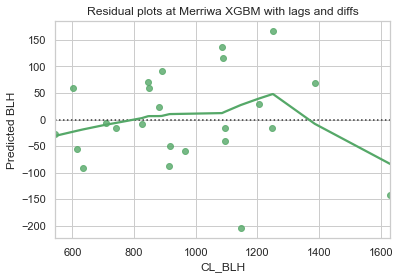

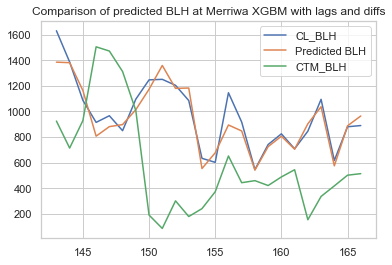

In [112]:
results_print(df_lidcombe_xgbm_wlags_v2, 'Merriwa XGBM with lags and diffs')

<h5>Light GBM</h5>

In [113]:
from lightgbm import LGBMRegressor

lgbm_model = LGBMRegressor()

#On external factors only
df_merriwa_lgbm_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', lgbm_model)
df_lidcombe_lgbm_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', lgbm_model)

#On external factors with lags
df_merriwa_lgbm_wlags = modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH', lgbm_model)
df_lidcombe_lgbm_wlags = modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH', lgbm_model)

#On external factors with lags and differences
df_merriwa_lgbm_wlags_v2 = modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH', lgbm_model)
df_lidcombe_lgbm_wlags_v2 = modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH', lgbm_model)


At Merriwa LGBM all features
Index of agreement:0.65167
Root mean squared error:362.40321
Mean absoluate error:314.66247
Mean bias error:314.66247
DTW distance:6204.35


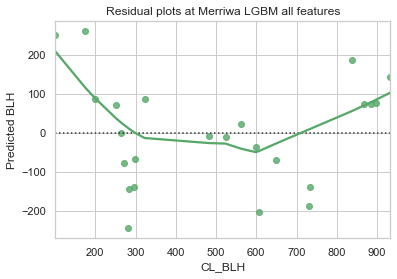

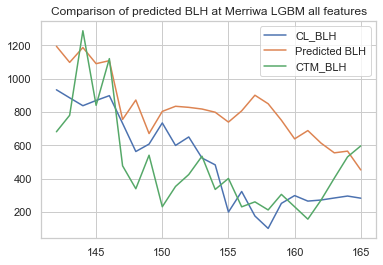

In [87]:
results_print(df_merriwa_lgbm_all, 'Merriwa LGBM all features')

At Lidcombe LGBM all features
Index of agreement:0.69446
Root mean squared error:270.12467
Mean absoluate error:226.50930
Mean bias error:88.98863
DTW distance:4192.09


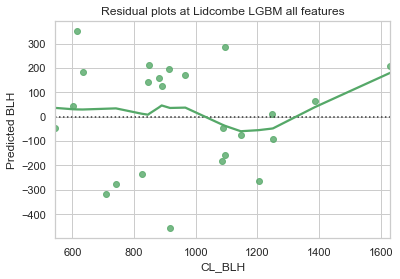

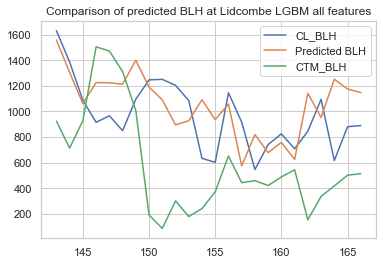

In [88]:
results_print(df_lidcombe_lgbm_all, 'Lidcombe LGBM all features')

At Merriwa LGBM with lags
Index of agreement:0.75226
Root mean squared error:272.84479
Mean absoluate error:236.00363
Mean bias error:224.96256
DTW distance:2127.48


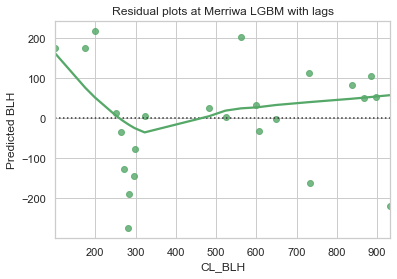

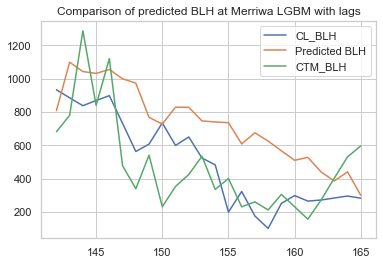

In [114]:
results_print(df_merriwa_lgbm_wlags, 'Merriwa LGBM with lags')

At Lidcombe LGBM with lags
Index of agreement:0.75213
Root mean squared error:255.45214
Mean absoluate error:213.66628
Mean bias error:48.95339
DTW distance:2869.95


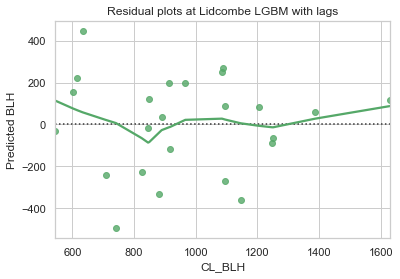

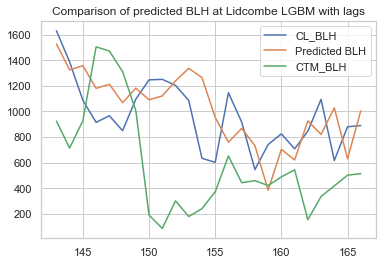

In [115]:
results_print(df_lidcombe_lgbm_wlags, 'Lidcombe LGBM with lags')

<h5>AdaBoost</h5>

In [116]:
from sklearn.ensemble import AdaBoostRegressor

ada_model = AdaBoostRegressor()

#On external factors only
df_merriwa_ada_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', ada_model)
df_lidcombe_ada_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', ada_model)

#On external factors with lags
df_merriwa_ada_wlags = modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH', ada_model)
df_lidcombe_ada_wlags = modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH', ada_model)

#On external factors with lags and differences
df_merriwa_ada_wlags_v2 = modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH', ada_model)
df_lidcombe_ada_wlags_v2 = modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH', ada_model)


When you rerun- you dont get same answer..?? Not stable perhaps discard

At Merriwa ADA all features
Index of agreement:0.73210
Root mean squared error:313.15290
Mean absoluate error:280.09576
Mean bias error:278.14027
DTW distance:5769.52


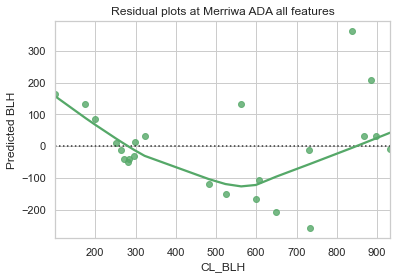

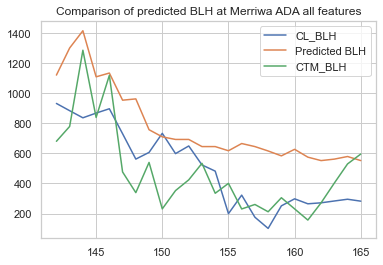

In [117]:
results_print(df_merriwa_ada_all, 'Merriwa ADA all features')

At Lidcombe ADA all features
Index of agreement:0.52126
Root mean squared error:289.54916
Mean absoluate error:242.02243
Mean bias error:118.99159
DTW distance:3799.30


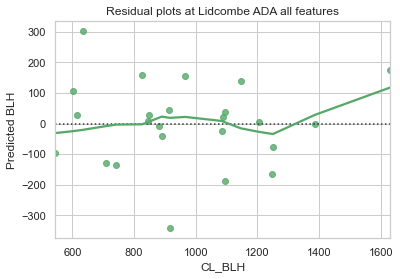

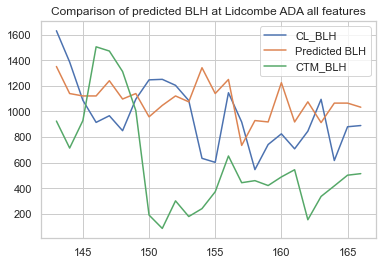

In [118]:
results_print(df_lidcombe_ada_all, 'Lidcombe ADA all features')

At Merriwa ADA with lags
Index of agreement:0.80034
Root mean squared error:212.89944
Mean absoluate error:177.45885
Mean bias error:167.59187
DTW distance:3280.96


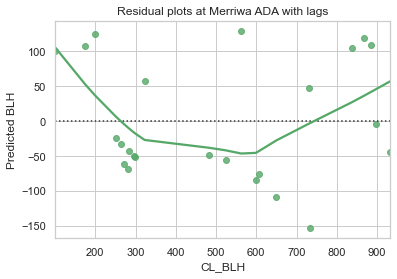

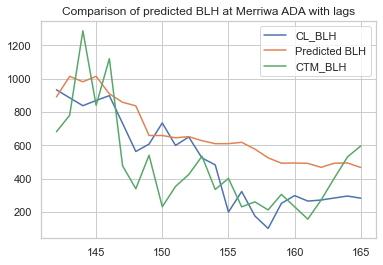

In [119]:
results_print(df_merriwa_ada_wlags, 'Merriwa ADA with lags')

At Lidcombe ADA with lags
Index of agreement:0.76212
Root mean squared error:223.78832
Mean absoluate error:176.39996
Mean bias error:58.31220
DTW distance:2159.78


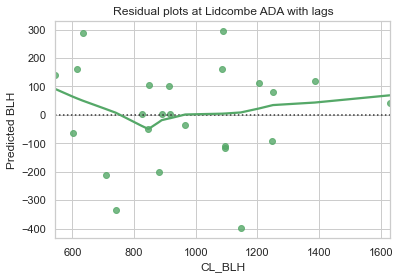

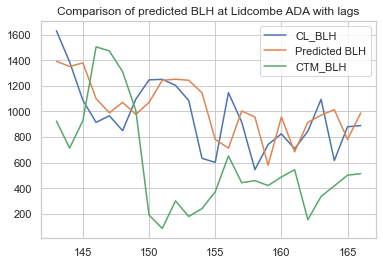

In [120]:
results_print(df_lidcombe_ada_wlags, 'Lidcombe ADA with lags')

<h5>Random forest</h5>

Also not stable - forests typically dont converge i guess..

In [121]:
from sklearn.ensemble import RandomForestRegressor

def rf_modeller(df, feature_list, target):
    '''
    Define train test split
    '''
    train = df.head(142).dropna()
    test = df.tail(24)
    #These are different periods for Merriwa and Lidcombe!!!
    
    X_train = train[feature_list]
    X_test = test[feature_list]
    
    y_train = train[target]
    y_test = test[target]
    
    '''
    Train model - keep default params
    '''
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    
    '''
    Predict
    '''
    rf_predict = rf.predict(X_test)
    
    '''
    Write to dataframe
    '''
    df_result = pd.DataFrame(y_test)
    df_result['Predicted BLH'] =  rf_predict
    df_result['CTM_BLH'] = test['CTM_BLH'] 
    return df_result, rf

In [122]:
def feature_importance_plot(model, feature_list):
    feat_importances = pd.Series(model.feature_importances_, index=feature_list)
    feat_importances.nlargest(14).plot(kind='barh')

In [123]:
#Models

#On external factors only
df_rf_merriwa_all, rf_merriwa_all = rf_modeller(df_merriwa_filled, feature_list_all, 'CL_BLH')
df_rf_lidcombe_all, rf_lidcombe_all = rf_modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH')

#On external factors with lags
df_rf_merriwa_wlags, rf_merriwa_wlags = rf_modeller(df_merriwa_wlags, feature_list_all_wlags, 'CL_BLH')
df_rf_lidcombe_wlags, rf_lidcombe_wlags = rf_modeller(df_lidcombe_wlags, feature_list_all_wlags, 'CL_BLH')

#On external factors with lags and differences
df_rf_merriwa_wlags_v2, rf_merriwa_v3 = rf_modeller(df_merriwa_wlags, feature_list_all_v3, 'CL_BLH')
df_rf_lidcombe_wlags_v2, rf_lidcombe_v3 = rf_modeller(df_lidcombe_wlags, feature_list_all_v3, 'CL_BLH')

At Merriwa RF all features
Index of agreement:0.72163
Root mean squared error:342.05834
Mean absoluate error:295.03874
Mean bias error:283.33249
DTW distance:5564.08


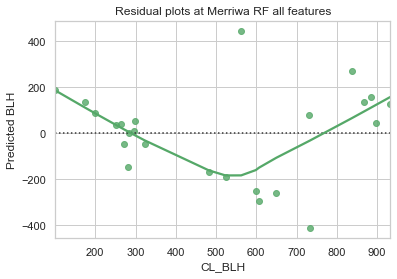

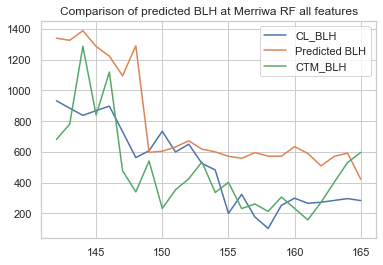

In [124]:
results_print(df_rf_merriwa_all, 'Merriwa RF all features')

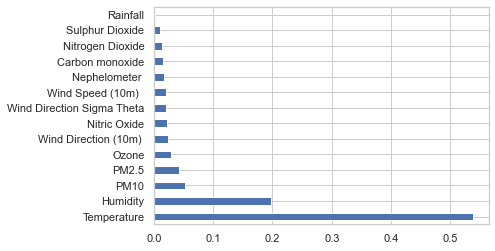

In [93]:
feature_importance_plot(rf_merriwa_all, feature_list_all)

At Lidcombe RF all features
Index of agreement:0.66291
Root mean squared error:252.34644
Mean absoluate error:207.79473
Mean bias error:19.70585
DTW distance:2917.78


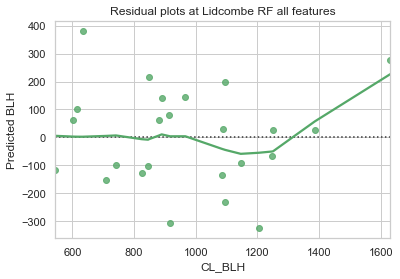

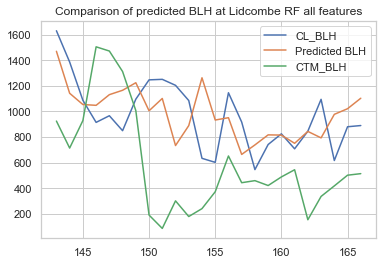

In [119]:
results_print(df_rf_lidcombe_all, 'Lidcombe RF all features')

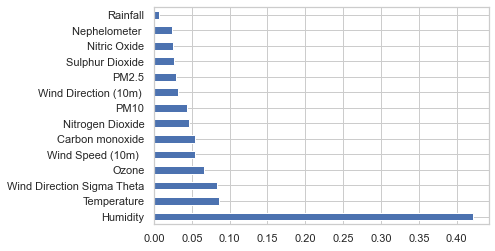

In [120]:
feature_importance_plot(rf_lidcombe_all, feature_list_all)

At Merriwa RF with lags
Index of agreement:0.79540
Root mean squared error:199.00839
Mean absoluate error:163.27881
Mean bias error:132.51560
DTW distance:2795.47


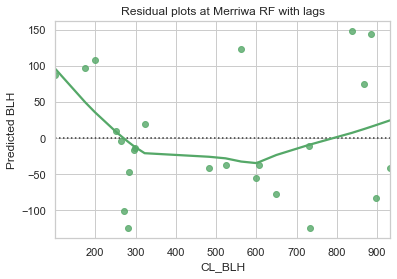

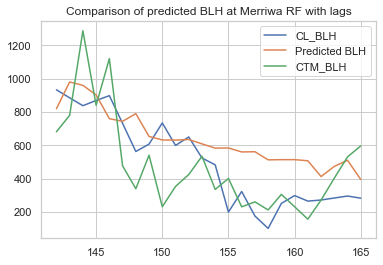

In [116]:
results_print(df_rf_merriwa_wlags, 'Merriwa RF with lags')

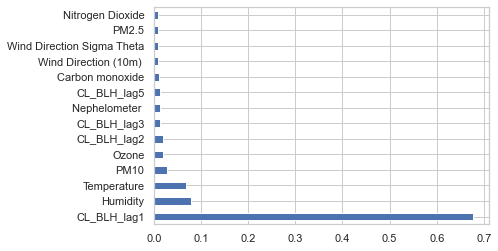

In [117]:
feature_importance_plot(rf_merriwa_wlags, feature_list_all_wlags)

Super interesting plot. The previous hour is the best indicator of the next hour's BLH. Heh

At Lidcombe RF with lags
Index of agreement:0.73625
Root mean squared error:252.34277
Mean absoluate error:198.54101
Mean bias error:58.93557
DTW distance:2106.35


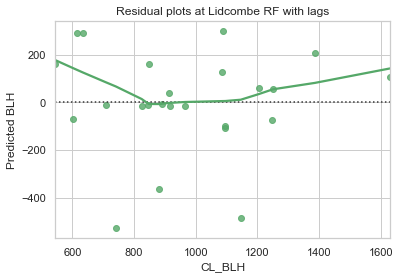

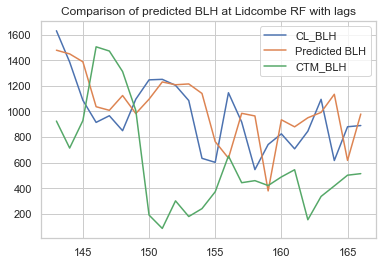

In [122]:
results_print(df_rf_lidcombe_wlags, 'Lidcombe RF with lags')

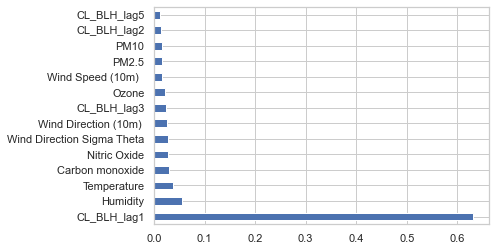

In [125]:
feature_importance_plot(rf_lidcombe_wlags, feature_list_all_wlags)

Same thing in Lidcombe. Cool

At Merriwa RF with lags and diff
Index of agreement:0.86797
Root mean squared error:152.55790
Mean absoluate error:115.57590
Mean bias error:48.45296
DTW distance:3565.16


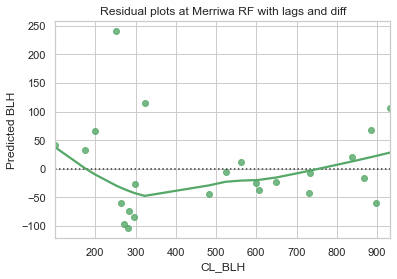

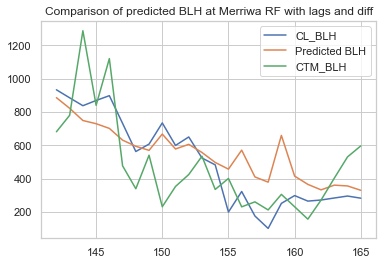

In [127]:
results_print(df_rf_merriwa_wlags_v2, 'Merriwa RF with lags and diff')

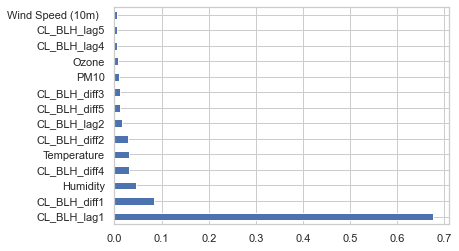

In [128]:
feature_importance_plot(rf_merriwa_v3, feature_list_all_v3)

<h5>Bagging regressor using linear SVR</h5>

In [129]:
from sklearn.ensemble import BaggingRegressor
from sklearn import svm

bagged_SVR_model = BaggingRegressor(base_estimator = svm.LinearSVR())

df_merriwa_svr_all = modeller(df_merriwa_filled, feature_list_all, 'CL_BLH', bagged_SVR_model)
df_lidcombe_svr_all = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', bagged_SVR_model)

C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Thomas\Anaconda3\lib\site-packages\sklearn\svm\_base.py:986: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iter

At Merriwa SVR all features
Index of agreement:0.64064
Root mean squared error:354.85565
Mean absoluate error:315.50219
Mean bias error:312.51881
DTW distance:6069.94


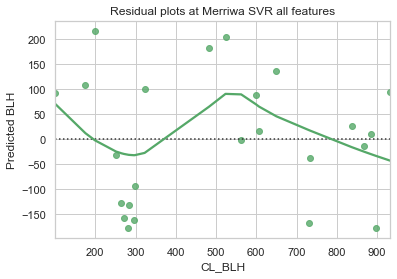

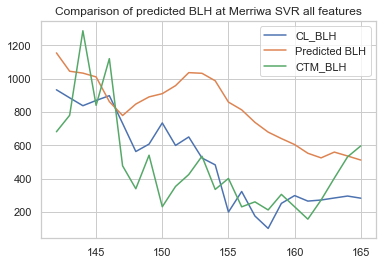

In [125]:
results_print(df_merriwa_svr_all, 'Merriwa SVR all features')

At Lidcombe SVR all features
Index of agreement:0.62429
Root mean squared error:234.61773
Mean absoluate error:196.57186
Mean bias error:32.12748
DTW distance:3128.60


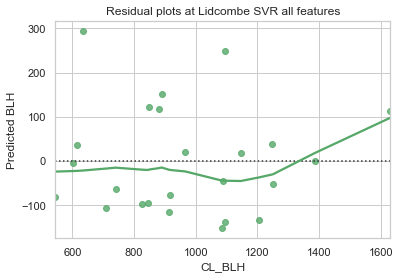

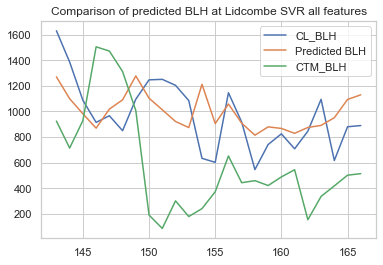

In [126]:
results_print(df_lidcombe_svr_all, 'Lidcombe SVR all features')

<h5>Simple regression model with temp and humidity</h5>

In [132]:
feature_set_1 = ['Temperature', 'Humidity']

In [133]:
'''
Linear regression trainer
'''
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression()

df_merriwa_lr_select1 = modeller(df_merriwa_filled, feature_set_1, 'CL_BLH', lr_model)
df_lidcombe_lr_select1 = modeller(df_lidcombe_filled, feature_list_all, 'CL_BLH', lr_model)

At LR Merriwa Temp and Humid
Index of agreement:0.70870
Root mean squared error:326.99635
Mean absoluate error:308.80200
Mean bias error:308.80200
DTW distance:6008.05


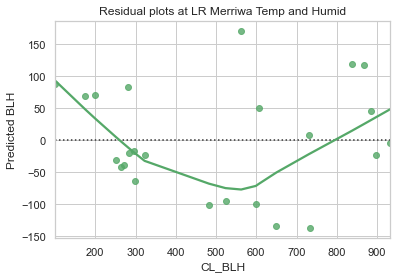

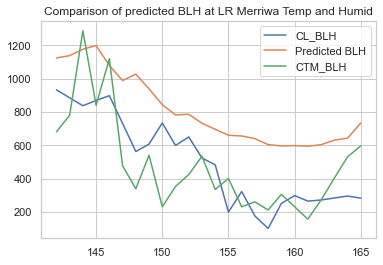

In [129]:
results_print(df_merriwa_lr_select1, 'LR Merriwa Temp and Humid')

At LR Lidcombe Temp and Humid
Index of agreement:0.37877
Root mean squared error:338.96714
Mean absoluate error:288.07691
Mean bias error:175.73330
DTW distance:5483.54


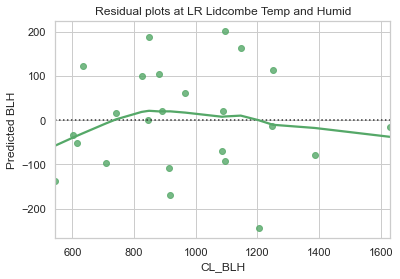

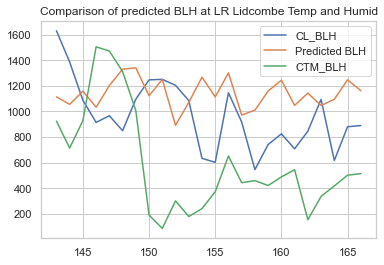

In [130]:
results_print(df_lidcombe_lr_select1, 'LR Lidcombe Temp and Humid')

<h5> Summary section </h5>

NB: you need to have run the models below to plot.

In [134]:
def combine_data_plots(df_filled, results_df, col_names_df):
    time_stamp_index = df_filled.tail(24)['datetime']

    df_combined = pd.DataFrame(df_filled.tail(24)['CL_BLH'])

    for i in range(0, len(results_df)):
        df_combined[col_names_df[i]] = results_df[i]

    df_combined = df_combined.set_index(time_stamp_index)
    
    return df_combined


In [135]:
'''
Combining data for plots -define function
'''

results_df_merriwa = [df_merriwa_filled.tail(24)['CTM_BLH'],df_merriwa_filled.tail(24)['WRF_BLH'], df_merriwa_xgbm_all['Predicted BLH'], 
              df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH'], 
              df_rf_merriwa_all['Predicted BLH'], df_merriwa_svr_all['Predicted BLH'], 
              df_merriwa_lr_select1['Predicted BLH']]

results_df_lidcombe = [df_lidcombe_filled.tail(24)['CTM_BLH'],df_lidcombe_filled.tail(24)['WRF_BLH'], df_lidcombe_xgbm_all['Predicted BLH'], 
              df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH'], 
              df_rf_lidcombe_all['Predicted BLH'], df_lidcombe_svr_all['Predicted BLH'], 
              df_lidcombe_lr_select1['Predicted BLH']]

col_names_df = ['CTM BLH','WRF BLH', 'XGBM all', 
                'LGBM all', 'AdaBoost all', 
                'Random forest all', 'Bagged LinearSVR all', 
                ' Lin Reg Temp and Humidity']


df_combined_predicted_merriwa = combine_data_plots(df_merriwa_filled, results_df_merriwa, col_names_df)
df_combined_predicted_lidcombe = combine_data_plots(df_lidcombe_filled, results_df_lidcombe, col_names_df)

In [137]:
'''
Plots - define a function
'''
def combined_predicted_plots(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

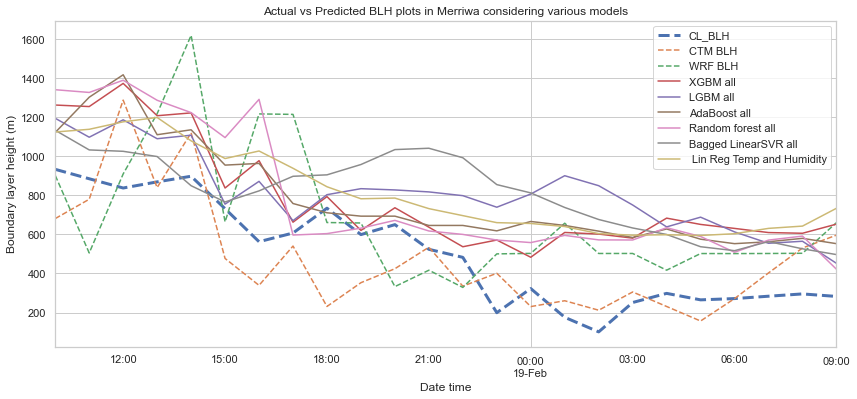

In [138]:
combined_predicted_plots(df_combined_predicted_merriwa, 'Actual vs Predicted BLH plots in Merriwa considering various models')

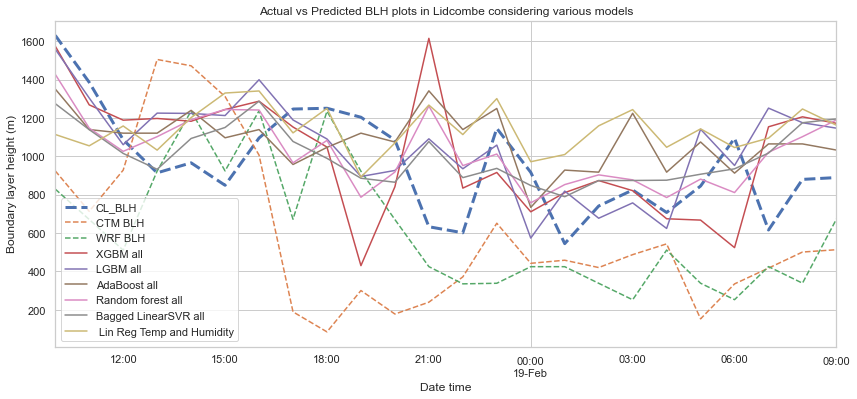

In [139]:
combined_predicted_plots(df_combined_predicted_lidcombe, 'Actual vs Predicted BLH plots in Lidcombe considering various models')

<h5>Using BL diff as a predictor</h5>

BL diff = CL_BLH - CTM_BLH i.e. the difference between the actual BLH and predicted BLH from CT model

How does this work if we include this as predictor?

feature_list_all_v2 has BL_diff included 

In [131]:
#Various ensemble methods on Merriwa
#Exclude bagged SVR
df_merriwa_xgbm_v2 = modeller(df_merriwa_filled, feature_list_all_v2, 'CL_BLH', xgbm_model)
df_merriwa_lgbm_v2 = modeller(df_merriwa_filled, feature_list_all_v2, 'CL_BLH', lgbm_model)
df_merriwa_ada_v2 = modeller(df_merriwa_filled, feature_list_all_v2, 'CL_BLH', ada_model)
df_merriwa_rf_v2, rf_merriwa_v2 = rf_modeller(df_merriwa_filled, feature_list_all_v2, 'CL_BLH')
# df_merriwa_svr_v2 = modeller(df_merriwa_filled, feature_list_all_v2, 'CL_BLH', bagged_SVR_model)


#Various ensemble methods at Lidcombe
df_lidcombe_xgbm_v2 = modeller(df_lidcombe_filled, feature_list_all_v2, 'CL_BLH', xgbm_model)
df_lidcombe_lgbm_v2 = modeller(df_lidcombe_filled, feature_list_all_v2, 'CL_BLH', lgbm_model)
df_lidcombe_ada_v2 = modeller(df_lidcombe_filled, feature_list_all_v2, 'CL_BLH', ada_model)
df_lidcombe_rf_v2, rf_lidcombe_v2 = rf_modeller(df_lidcombe_filled, feature_list_all_v2, 'CL_BLH')
# df_lidcombe_svr_v2 = modeller(df_lidcombe_filled, feature_list_all_v2, 'CL_BLH', bagged_SVR_model)


C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
C:\Users\Thomas\Anaconda3\lib\site-packages\xgboost\data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


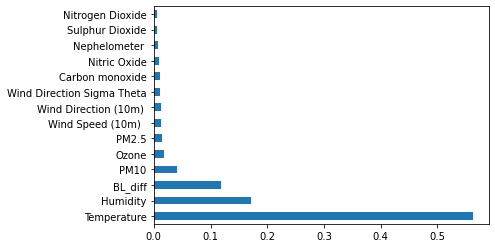

In [43]:
feature_importance_plot(rf_merriwa_v2, feature_list_all_v2)

Not as important as I was expecting

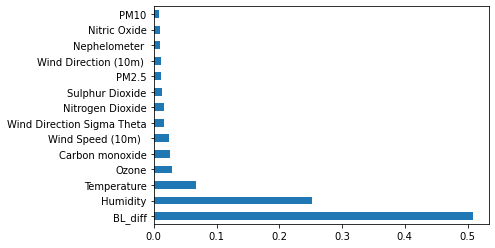

In [55]:
feature_importance_plot(rf_lidcombe_v2, feature_list_all_v2)

Now we're talking...

In [145]:
def combined_predicted_plots_v2(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
    
    
    ax.lines[6].set_color('red')
    ax.lines[6].set_linestyle('dotted')
    ax.lines[6].set_linewidth(2)
    
    ax.lines[7].set_color('purple')
    ax.lines[7].set_linestyle('dotted')
    ax.lines[7].set_linewidth(2)

    ax.lines[8].set_color('brown')
    ax.lines[8].set_linestyle('dotted')
    ax.lines[8].set_linewidth(2)

    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

In [140]:
results_df_merriwa_v2 = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],df_merriwa_xgbm_all['Predicted BLH'], 
              df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH'], 
              df_merriwa_xgbm_v2['Predicted BLH'],df_merriwa_lgbm_v2['Predicted BLH'], 
             df_merriwa_ada_v2['Predicted BLH']]

results_df_lidcombe_v2 = [df_lidcombe_filled.tail(24)['CTM_BLH'],df_lidcombe_filled.tail(24)['WRF_BLH'], df_lidcombe_xgbm_all['Predicted BLH'], 
              df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH'], 
              df_lidcombe_xgbm_v2['Predicted BLH'],df_lidcombe_lgbm_v2['Predicted BLH'], 
             df_lidcombe_ada_v2['Predicted BLH']]


col_names_df_v2 = ['CTM BLH','WRF BLH', 'XGBM all', 
                'LGBM all', 'AdaBoost all', 
                'XGBM with BL Diff','LGBM with BL diff', 
                   'AdaBoost with BL diff']

df_combined_predicted_merriwa_v2 = combine_data_plots(df_merriwa_filled, results_df_merriwa_v2, col_names_df_v2)
df_combined_predicted_lidcombe_v2 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_v2, col_names_df_v2)



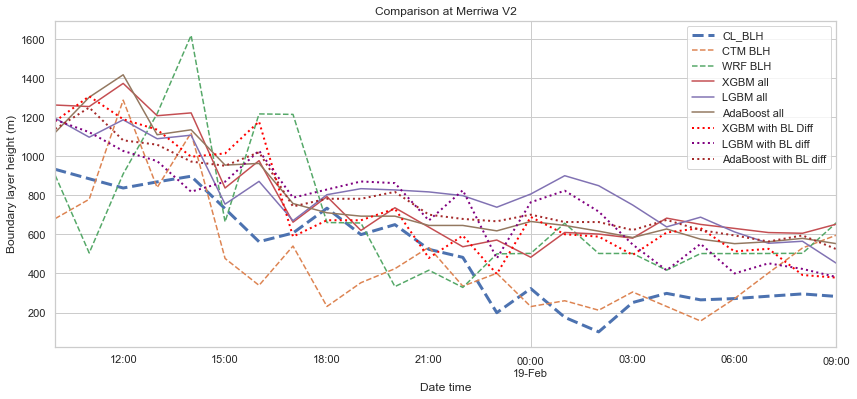

In [146]:
combined_predicted_plots_v2(df_combined_predicted_merriwa_v2, 'Comparison at Merriwa V2')

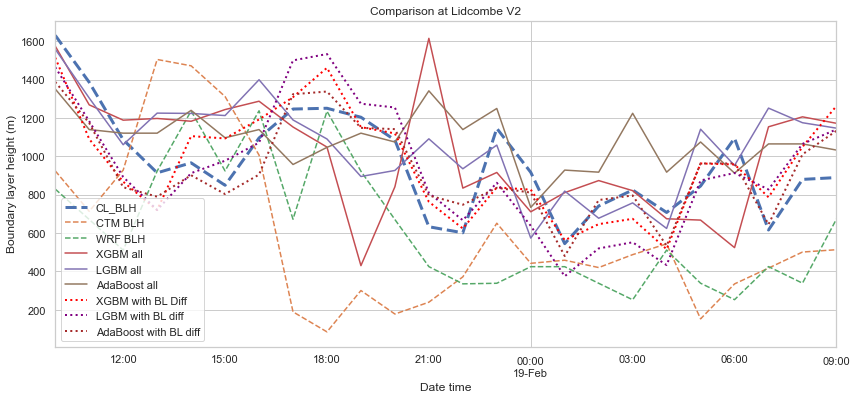

In [147]:
combined_predicted_plots_v2(df_combined_predicted_lidcombe_v2, 'Comparison at Lidcombe V2')

At AdaBoost Lidcombe - with BL DIFF
Index of agreement:0.89132
Root mean squared error:156.77291
Mean absoluate error:119.73050
Mean bias error:-53.24379
DTW distance:2487.86


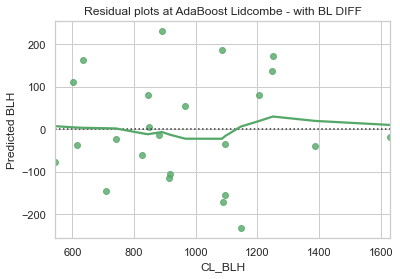

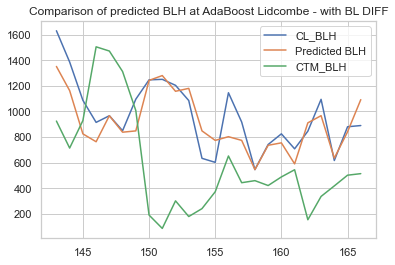

In [59]:
results_print(df_lidcombe_ada_v2, 'AdaBoost Lidcombe - with BL DIFF')

<h5>Incorporating lags into feature</h5>

In [151]:
results_df_merriwa_v3 = [df_merriwa_filled.tail(24)['CTM_BLH'],df_merriwa_filled.tail(24)['WRF_BLH'], 
        df_merriwa_xgbm_all['Predicted BLH'], df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH'], 
        df_merriwa_xgbm_wlags['Predicted BLH'], df_merriwa_lgbm_wlags['Predicted BLH'], df_merriwa_ada_wlags['Predicted BLH']]

results_df_lidcombe_v3 = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_all['Predicted BLH'],df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH'], 
        df_lidcombe_xgbm_wlags['Predicted BLH'],df_lidcombe_lgbm_wlags['Predicted BLH'], df_lidcombe_ada_wlags['Predicted BLH']]


col_names_df_v3 = ['CTM BLH', 'WRF BLH',
           'XGBM all', 'LGBM all', 'AdaBoost all', 
           'XGBM with lags', 'LGBM with lags', 'AdaBoost with lags']

df_combined_predicted_merriwa_v3 = combine_data_plots(df_merriwa_filled, results_df_merriwa_v3, col_names_df_v3)
df_combined_predicted_lidcombe_v3 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_v3, col_names_df_v3)


In [148]:
def combined_predicted_plots_v3(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
    
    
    ax.lines[6].set_color('magenta')
    ax.lines[6].set_linestyle('dashdot')
    ax.lines[6].set_linewidth(2)
    
    ax.lines[7].set_color('purple')
    ax.lines[7].set_linestyle('dashdot')
    ax.lines[7].set_linewidth(2)

    ax.lines[8].set_color('brown')
    ax.lines[8].set_linestyle('dashdot')
    ax.lines[8].set_linewidth(2)

#     ax.lines[8].set_color('olive')
#     ax.lines[8].set_linestyle('dashdot')
#     ax.lines[8].set_linewidth(2)
    
#     ax.lines[9].set_color('magenta')
#     ax.lines[9].set_linestyle('dashdot')
#     ax.lines[9].set_linewidth(2)

#     ax.lines[10].set_color('purple')
#     ax.lines[10].set_linestyle('dashdot')
#     ax.lines[10].set_linewidth(2)
    
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

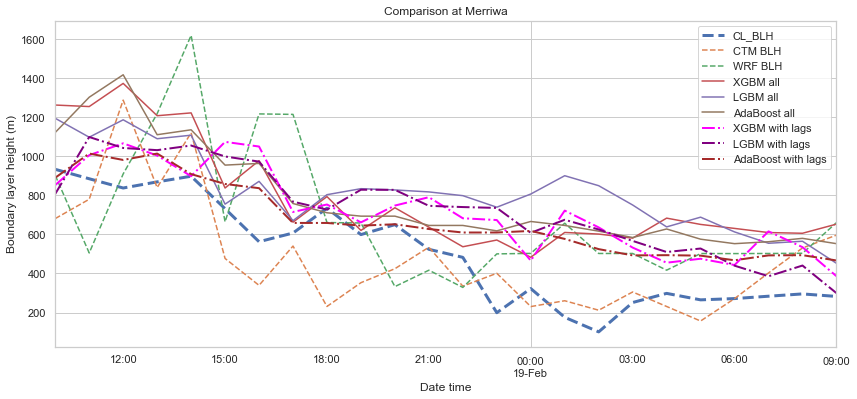

In [152]:
combined_predicted_plots_v3(df_combined_predicted_merriwa_v3, 'Comparison at Merriwa')

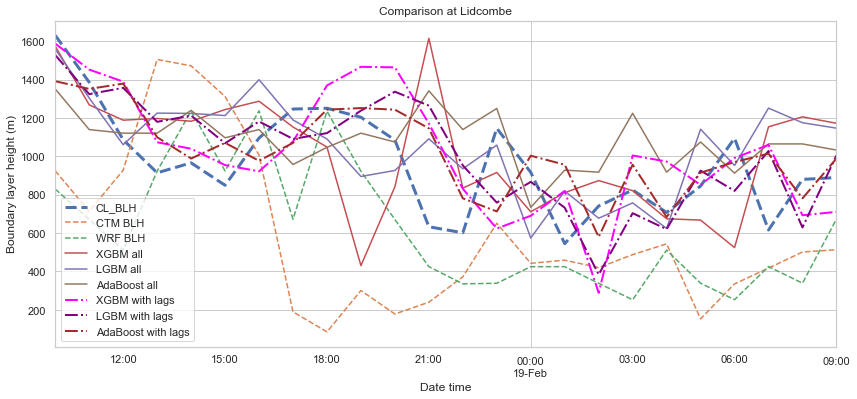

In [153]:
combined_predicted_plots_v3(df_combined_predicted_lidcombe_v3, 'Comparison at Lidcombe')

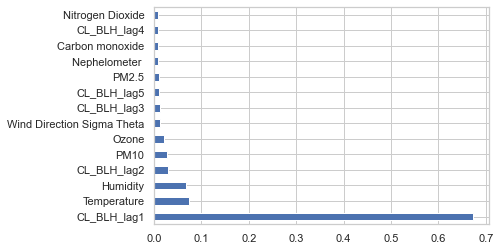

In [154]:
feature_importance_plot(rf_merriwa_wlags, feature_list_all_wlags)

So here we see that lag 1 is a very important feature

<h5>Comparing lags to BL diff feature</h5>

In [78]:
results_df_merriwa_v4 = [df_merriwa_filled.tail(24)['CTM_BLH'], 
        df_merriwa_xgbm_v2['Predicted BLH'], df_merriwa_lgbm_v2['Predicted BLH'], df_merriwa_ada_v2['Predicted BLH'], 
        df_merriwa_xgbm_wlags['Predicted BLH'], df_merriwa_lgbm_wlags['Predicted BLH'], df_merriwa_ada_wlags['Predicted BLH']]

results_df_lidcombe_v4 = [df_lidcombe_filled.tail(24)['CTM_BLH'], 
        df_lidcombe_xgbm_v2['Predicted BLH'],df_lidcombe_lgbm_v2['Predicted BLH'], df_lidcombe_ada_v2['Predicted BLH'], 
        df_lidcombe_xgbm_wlags['Predicted BLH'],df_lidcombe_lgbm_wlags['Predicted BLH'], df_lidcombe_ada_wlags['Predicted BLH']]


col_names_df_v4 = ['CTM BLH', 
           'XGBM with BL diff', 'LGBM with BL diff', 'AdaBoost with BL diff', 
           'XGBM with lags', 'LGBM with lags', 'AdaBoost with lags']

df_combined_predicted_merriwa_v4 = combine_data_plots(df_merriwa_filled, results_df_merriwa_v4, col_names_df_v4)
df_combined_predicted_lidcombe_v4 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_v4, col_names_df_v4)


In [79]:
def combined_predicted_plots_v4(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    
    #With BL diff dfs
    ax.lines[2].set_color('green')
    ax.lines[2].set_linestyle('dotted')
    ax.lines[2].set_linewidth(2)
    
    ax.lines[3].set_color('red')
    ax.lines[3].set_linestyle('dotted')
    ax.lines[3].set_linewidth(2)

    ax.lines[4].set_color('purple')
    ax.lines[4].set_linestyle('dotted')
    ax.lines[4].set_linewidth(2)
    
    #With lags df
    ax.lines[5].set_color('olive')
    ax.lines[5].set_linestyle('dashdot')
    ax.lines[5].set_linewidth(2)
    
    ax.lines[6].set_color('magenta')
    ax.lines[6].set_linestyle('dashdot')
    ax.lines[6].set_linewidth(2)

    ax.lines[7].set_color('purple')
    ax.lines[7].set_linestyle('dashdot')
    ax.lines[7].set_linewidth(2)
    
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

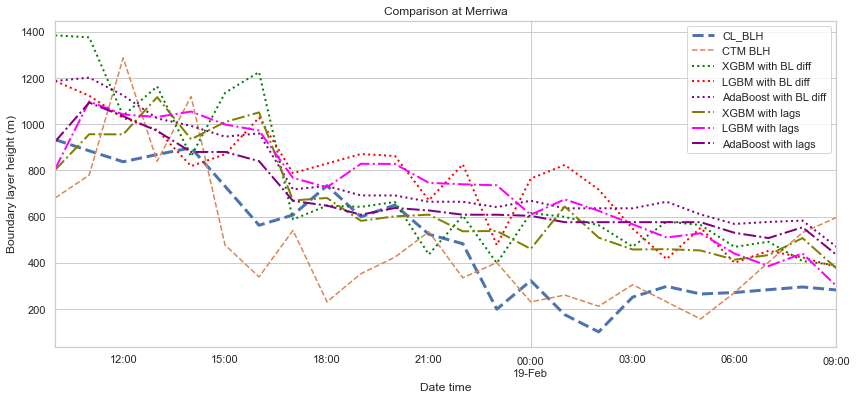

In [80]:
combined_predicted_plots_v4(df_combined_predicted_merriwa_v4, 'Comparison at Merriwa')

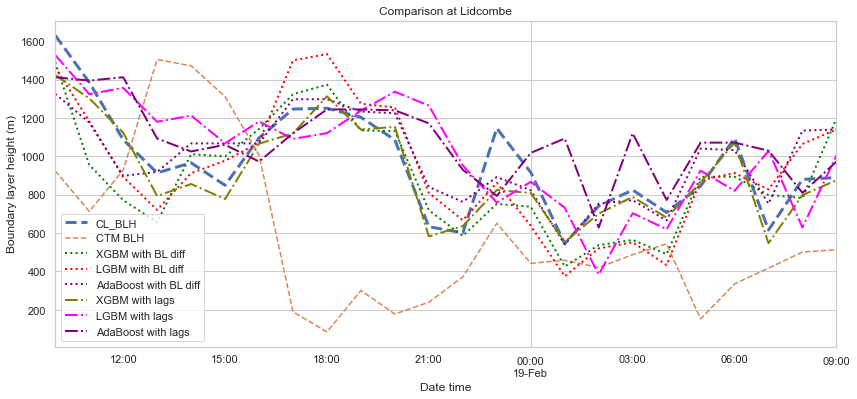

In [81]:
combined_predicted_plots_v4(df_combined_predicted_lidcombe_v4, 'Comparison at Lidcombe')

So here we see - its a bit hard... - that predictors with lags perform better than without lags

<h5>Comparing lags to diff</h5>

In [85]:
results_df_merriwa_v5 = [df_merriwa_filled.tail(24)['CTM_BLH'], 
        df_merriwa_xgbm_wlags['Predicted BLH'], df_merriwa_lgbm_wlags['Predicted BLH'], df_merriwa_ada_wlags['Predicted BLH'],
        df_merriwa_xgbm_wlags_v2['Predicted BLH'], df_merriwa_lgbm_wlags_v2['Predicted BLH'], df_merriwa_ada_wlags_v2['Predicted BLH']]

results_df_lidcombe_v5 = [df_lidcombe_filled.tail(24)['CTM_BLH'], 
        df_lidcombe_xgbm_wlags['Predicted BLH'],df_lidcombe_lgbm_wlags['Predicted BLH'], df_lidcombe_ada_wlags['Predicted BLH'],
        df_lidcombe_xgbm_wlags_v2['Predicted BLH'],df_lidcombe_lgbm_wlags_v2['Predicted BLH'], df_lidcombe_ada_wlags_v2['Predicted BLH']]


col_names_df_v5 = ['CTM BLH', 
           'XGBM with lags', 'LGBM with lags', 'AdaBoost with lags',
           'XGBM with lags + diff', 'LGBM with lags + diff', 'AdaBoost with lags + diff']

df_combined_predicted_merriwa_v5 = combine_data_plots(df_merriwa_filled, results_df_merriwa_v5, col_names_df_v5)
df_combined_predicted_lidcombe_v5 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_v5, col_names_df_v5)


In [87]:
def combined_predicted_plots_v5(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    
#     #With BL diff dfs
#     ax.lines[2].set_color('green')
#     ax.lines[2].set_linestyle('dotted')
#     ax.lines[2].set_linewidth(2)
    
#     ax.lines[3].set_color('red')
#     ax.lines[3].set_linestyle('dotted')
#     ax.lines[3].set_linewidth(2)

#     ax.lines[4].set_color('purple')
#     ax.lines[4].set_linestyle('dotted')
#     ax.lines[4].set_linewidth(2)
    
    #With lags df
    ax.lines[2].set_color('olive')
    ax.lines[2].set_linestyle('dashdot')
    ax.lines[2].set_linewidth(2)
    
    ax.lines[3].set_color('magenta')
    ax.lines[3].set_linestyle('dashdot')
    ax.lines[3].set_linewidth(2)

    ax.lines[4].set_color('purple')
    ax.lines[4].set_linestyle('dashdot')
    ax.lines[4].set_linewidth(2)
    
    #With lags + diff
    ax.lines[5].set_color('olive')
#     ax.lines[5].set_linestyle('dashdot')
#     ax.lines[5].set_linewidth(2)
    
    ax.lines[6].set_color('magenta')
#     ax.lines[6].set_linestyle('dashdot')
#     ax.lines[6].set_linewidth(2)

    ax.lines[7].set_color('purple')
#     ax.lines[7].set_linestyle('dashdot')
#     ax.lines[7].set_linewidth(2)
    
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')

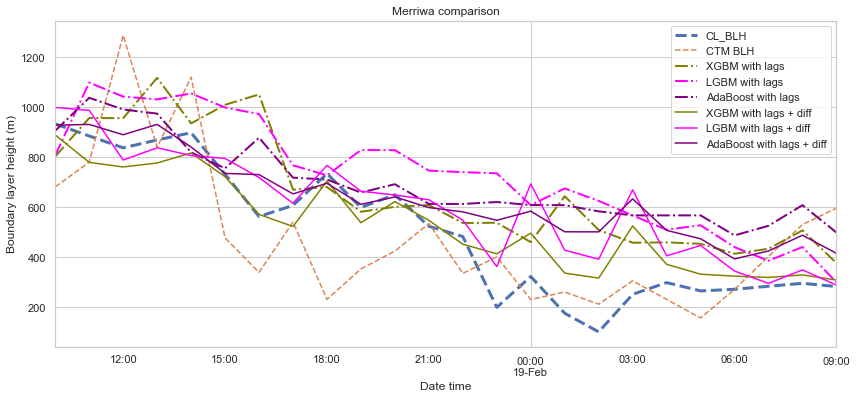

In [88]:
combined_predicted_plots_v5(df_combined_predicted_merriwa_v5, "Merriwa comparison")

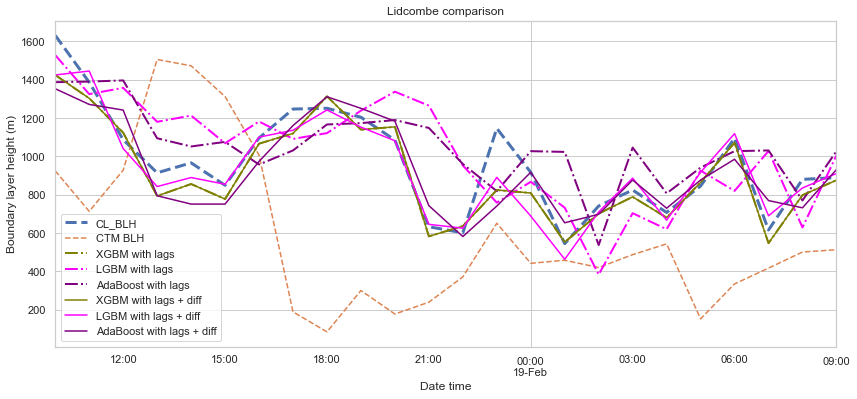

In [89]:
combined_predicted_plots_v5(df_combined_predicted_lidcombe_v5, "Lidcombe comparison")

<h4>More presentable results</h4>

For Friday

In [155]:
results_df_merriwa_extfact = [df_merriwa_filled.tail(24)['CTM_BLH'],df_merriwa_filled.tail(24)['WRF_BLH'], 
        df_merriwa_xgbm_all['Predicted BLH'], df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH']] 

results_df_lidcombe_extfact = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_all['Predicted BLH'],df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH']]
                         
col_names_df_extfact = ['CTM BLH', 'WRF BLH',
           'XGBM all external factors', 'LGBM all external factors', 'AdaBoost all external factors']

results_df_merriwa_wlags_v2 = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
        df_merriwa_xgbm_wlags_v2['Predicted BLH'], df_merriwa_lgbm_wlags_v2['Predicted BLH'], df_merriwa_ada_wlags_v2['Predicted BLH']]

results_df_lidcombe_wlags_v2 = [df_lidcombe_filled.tail(24)['CTM_BLH'],   df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_wlags_v2['Predicted BLH'],df_lidcombe_lgbm_wlags_v2['Predicted BLH'], df_lidcombe_ada_wlags_v2['Predicted BLH']]

col_names_df_wlags_v2 = ['CTM BLH', 'WRF BLH',
           'XGBM with lags and differences up to 5', 'LGBM with lags and differences up to 5', 'AdaBoost with lags and differences up to 5']

df_combined_predicted_merriwa_extfact = combine_data_plots(df_merriwa_filled, results_df_merriwa_extfact, col_names_df_extfact)
df_combined_predicted_lidcombe_extfact = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_extfact, col_names_df_extfact)

df_combined_predicted_merriwa_wlags_v2 = combine_data_plots(df_merriwa_filled, results_df_merriwa_wlags_v2, col_names_df_wlags_v2)
df_combined_predicted_lidcombe_wlags_v2 = combine_data_plots(df_lidcombe_filled, results_df_lidcombe_wlags_v2, col_names_df_wlags_v2)

In [156]:
def combined_predicted_plots_extfact(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM/WRF BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')
    plt.ylim(0,1800)

In [168]:
def combined_predicted_plots_wlags_v2(df, title):
    ax = df.plot(figsize = (14,6), title = title)
    #Change settings for CL_BLH
    ax.lines[0].set_linestyle('dashed')
    ax.lines[0].set_linewidth(3)
    #Change settings for CTM BLH
    ax.lines[1].set_linestyle('dashed')
    ax.lines[2].set_linestyle('dashed')
 
    #With lags df
    ax.lines[3].set_color('red')
    ax.lines[3].set_linestyle('dashdot')
    ax.lines[3].set_linewidth(2)
    
    ax.lines[4].set_color('purple')
    ax.lines[4].set_linestyle('dashdot')
    ax.lines[4].set_linewidth(2)

    ax.lines[5].set_color('brown')
    ax.lines[5].set_linestyle('dashdot')
    ax.lines[5].set_linewidth(2)
    
    #Reset legend
    ax.legend()
    plt.xlabel('Date time')
    plt.ylabel('Boundary layer height (m)')
    plt.ylim(0,1800)

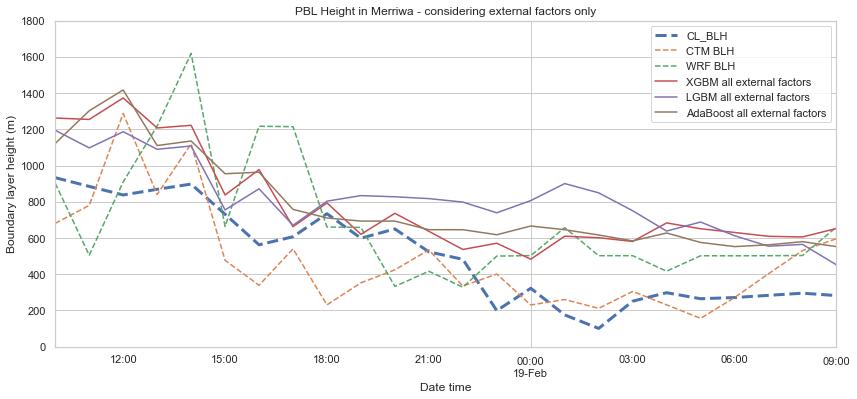

In [158]:
combined_predicted_plots_extfact(df_combined_predicted_merriwa_extfact, 'PBL Height in Merriwa - considering external factors only')

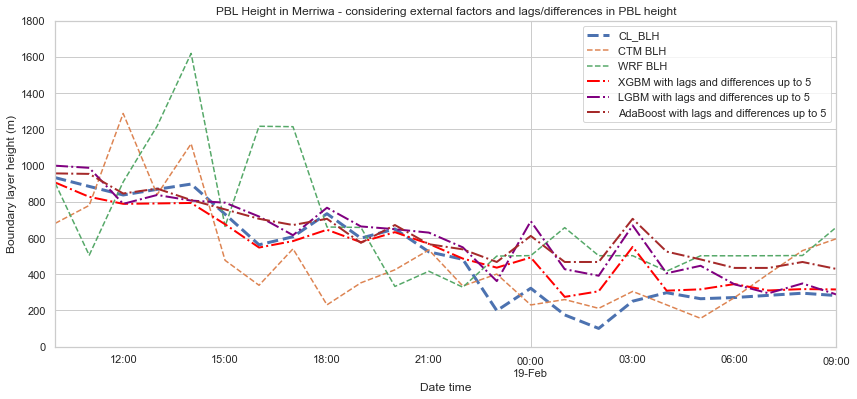

In [169]:
combined_predicted_plots_wlags_v2(df_combined_predicted_merriwa_wlags_v2, 'PBL Height in Merriwa - considering external factors and lags/differences in PBL height')

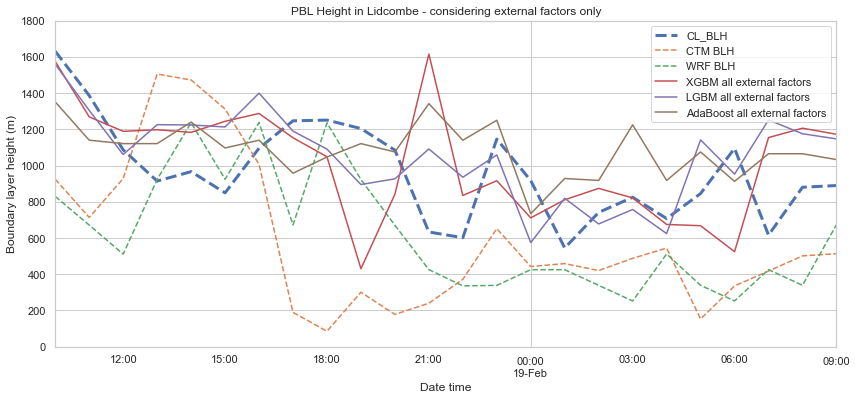

In [162]:
combined_predicted_plots_extfact(df_combined_predicted_lidcombe_extfact, 'PBL Height in Lidcombe - considering external factors only')

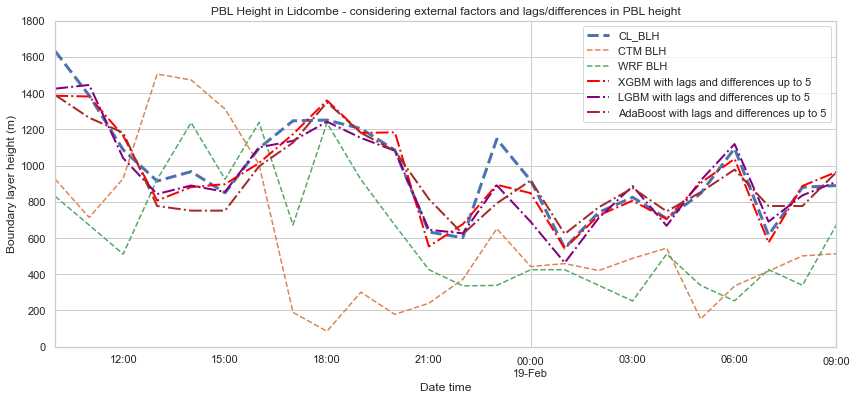

In [170]:
combined_predicted_plots_wlags_v2(df_combined_predicted_lidcombe_wlags_v2, 'PBL Height in Lidcombe - considering external factors and lags/differences in PBL height')

<h4>Writing a massive DF for all the results - for comparison purposes</h4>

In [164]:
results_df_merriwa_all = [df_merriwa_filled.tail(24)['CTM_BLH'], df_merriwa_filled.tail(24)['WRF_BLH'],
        df_merriwa_xgbm_all['Predicted BLH'], df_merriwa_lgbm_all['Predicted BLH'], df_merriwa_ada_all['Predicted BLH'],                   
        df_merriwa_xgbm_v2['Predicted BLH'], df_merriwa_lgbm_v2['Predicted BLH'], df_merriwa_ada_v2['Predicted BLH'], 
        df_merriwa_xgbm_wlags['Predicted BLH'], df_merriwa_lgbm_wlags['Predicted BLH'], df_merriwa_ada_wlags['Predicted BLH'],
        df_merriwa_xgbm_wlags_v2['Predicted BLH'], df_merriwa_lgbm_wlags_v2['Predicted BLH'], df_merriwa_ada_wlags_v2['Predicted BLH']]


results_df_lidcombe_all = [df_lidcombe_filled.tail(24)['CTM_BLH'], df_lidcombe_filled.tail(24)['WRF_BLH'],
        df_lidcombe_xgbm_all['Predicted BLH'], df_lidcombe_lgbm_all['Predicted BLH'], df_lidcombe_ada_all['Predicted BLH'],                   
        df_lidcombe_xgbm_v2['Predicted BLH'], df_lidcombe_lgbm_v2['Predicted BLH'], df_lidcombe_ada_v2['Predicted BLH'], 
        df_lidcombe_xgbm_wlags['Predicted BLH'], df_lidcombe_lgbm_wlags['Predicted BLH'], df_lidcombe_ada_wlags['Predicted BLH'],
        df_lidcombe_xgbm_wlags_v2['Predicted BLH'], df_lidcombe_lgbm_wlags_v2['Predicted BLH'], df_lidcombe_ada_wlags_v2['Predicted BLH']]


col_names_df_all = ['CTM BLH', 'WRF BLH', 
           'XGBM all', 'LGBM all', 'AdaBoost all',         
           'XGBM with BL diff', 'LGBM with BL diff', 'AdaBoost with BL diff', 
           'XGBM with lags (up to 5)', 'LGBM with lags (up to 5)', 'AdaBoost with lags (up to 5)',
            'XGBM with lags and differences (up to 5)', 'LGBM with lags and differences (up to 5)', 'AdaBoost with lags and differences (up to 5)',]


In [165]:
#Function that writes out df for all results
def df_stat_results_combined(df_filled, results_df, col_names_df):
    index_dict = {0:'IOA', 1:'RMSE', 2:'MAE', 3:'MBE', 4:'DTW DIST'}
    
    y_true = df_filled.tail(24)['CL_BLH']
    
    #The first one is the CTM model
    y_pred = results_df[0]
    
    #Intialises the DF
    df_combined = satistical_comps_on_df_to_df(y_true, y_pred)
    df_combined = df_combined.rename(columns = {0:'CTM model'})
    
    #Iterate
    for i in range(1, len(results_df)):
        y_pred_i = results_df[i]
        df_results_i = satistical_comps_on_df_to_df(y_true, y_pred_i)        
        df_combined[col_names_df[i]] = df_results_i

    df_combined = df_combined.rename(index = index_dict)    
    
    return df_combined

In [166]:
df_stat_results_combined(df_merriwa_filled, results_df_merriwa_all, col_names_df_all).to_csv('Merriwa_summary_v3.csv')

In [167]:
df_stat_results_combined(df_lidcombe_filled, results_df_lidcombe_all, col_names_df_all).to_csv('Lidcombe_summary_v3.csv')

That's pretty close....

ELM?

https://towardsdatascience.com/ml-approaches-for-time-series-4d44722e48fe

https://towardsdatascience.com/introduction-to-extreme-learning-machines-c020020ff82b

<h1>NOT USED - TK PLAY</H1>

<h4> Stationarity checks</h4>

In [18]:
from statsmodels.tsa.stattools import adfuller

#Augmented Dicky Fuller test for stationarity
#H0: Process is not stationary

def adf_test(series):
    adf_test_result = adfuller(series)
    print('ADF stat %0.5f' % adf_test_result[0])
    print('p-val %0.5f' % adf_test_result[1])
    
adf_test(df_merriwa['CL_BLH'])
adf_test(df_lidcombe['CL_BLH'])

#Looks stationary..

<h4>ARIMA</h4>

In [15]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [18]:
auto_arima_merriwa = auto_arima(df_merriwa_cl['CL_BLH'], trace = True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.54 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2282.558, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2283.058, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2283.277, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2280.793, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2284.761, Time=0.11 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.814 seconds


In [19]:
auto_arima_merriwa.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  166
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1139.396
Date:                Thu, 29 Jul 2021   AIC                           2280.793
Time:                        11:54:18   BIC                           2283.899
Sample:                             0   HQIC                          2282.054
                                - 166                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.841e+04   4885.664     11.955      0.000    4.88e+04     6.8e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.61   Jarque-Bera (JB):                15.07
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               0.49   Skew:                            -0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
arima_merriwa = ARIMA(df_merriwa_cl['CL_BLH'], order=(0,1,0))
print(arima_merriwa.fit().summary())

                               SARIMAX Results                                
Dep. Variable:                 CL_BLH   No. Observations:                  166
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -1139.396
Date:                Thu, 29 Jul 2021   AIC                           2280.793
Time:                        11:54:22   BIC                           2283.899
Sample:                             0   HQIC                          2282.054
                                - 166                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5.841e+04   4885.664     11.955      0.000    4.88e+04     6.8e+04
Ljung-Box (L1) (Q):                   1.61   Jarque-Bera (JB):                15.07
Prob(Q):                              0.20   Pr

In [52]:
t = ()

if not t:
    print('empty')

empty


In [54]:
t = []

stuff = (1,2,3)

t.extend(stuff)

tuple(t)

(1, 2, 3)

Cool. What does this mean?
How to use auto_arima to get params right?

Trad TS models lack the ability to fit causal relationships easily. Could extend this by predicting the predictors but that would require first feature selection.

Perhaps this could be briefly tried?